# **Implementing a Neural Network from Scratch in Python â€“ An Introduction**

A neural network is a series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that mimics the way the human brain operates. In this sense, neural networks refer to systems of neurons, either organic or artificial in nature. Neural networks can adapt to changing input; so the network generates the best possible result without needing to redesign the output criteria.

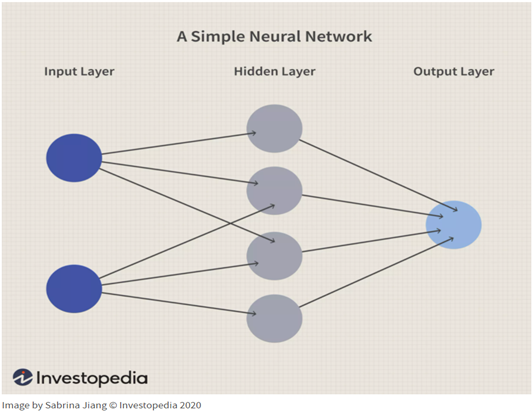

In this lab we will implement a simple 3-layer neural network from scratch.

###**Step 1: Import the Libraries**

First, we have to import the necessary libraries. Matplotlib is the most popular data visualization library in Python. It allows us to create figures and plots, and makes it very easy to produce static raster or vector files without the need for any GUIs. NumPy is a Python library used for working with arrays. It also has functions for working in domain of linear algebra, fourier transform, and matrices. Scikit-learn is a free machine learning library for Python. It features various algorithms like support vector machine, random forests, and k-neighbours, and it also supports Python numerical and scientific libraries like NumPy and SciPy.

In [18]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)


###**Step 2: Generating a Dataset**

Scikit-learn has some useful dataset generators, so we don't need to write the code ourselves. We will go with the make_moons function.

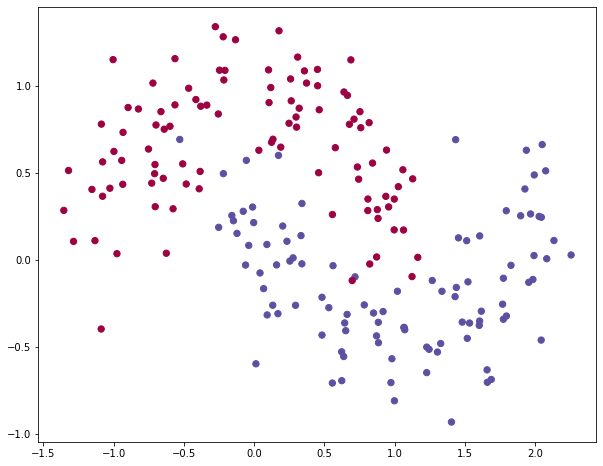

In [19]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)


The dataset we generated has two classes, plotted as red and blue points. The blue dots as male patients and the red dots as female patients, with the x- and y- axis being medical measurements. The data is not linearly separable, we cannot draw a straight line that separates the two classes. This means that linear classifiers, such as Logistic Regression, will not be able to fit the data. So, we will use the Neural Networks.

###**Step 3: Logistic Regression**

To demonstrate the point let's train a Logistic Regression classifier. It's input will be the x- and y-values and the output the predicted class (0 or 1). we use the Logistic Regression class from scikit-learn. 

In [20]:
# Train the Logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, y)


LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

Next, we will plot a function to plot a decision boundary.

In [21]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
  # Set min and max values and give it some padding
  x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
  y_min, y_max = X[:, 1].min() - .5, X[:, 1].max()+.5
  h = 0.01
  # Generate a grid of points with distance h between them
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  # Predict the function value for the whole gid
  Z = pred_func (np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  # Plot the contour and training examples
  plt.contourf(xx,yy, Z, Ñmap=plt.cm.Spectral)
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: The following kwargs were not used by contour: 'Ñmap'
  


Text(0.5, 1.0, 'Logistic Regression')

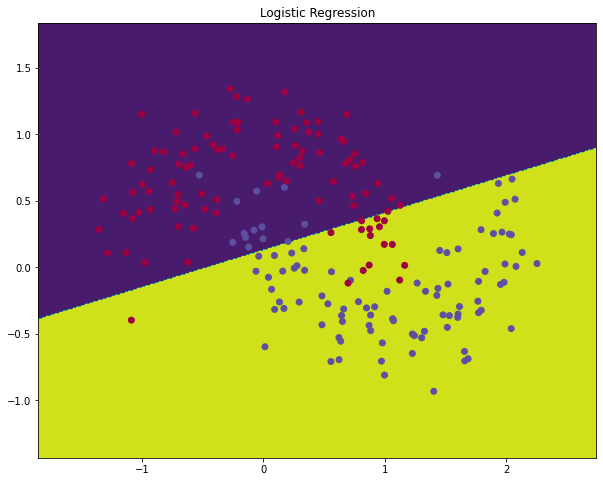

In [22]:
#plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")

The graph shows the decision boundary learned by our Logistic Regression classifier. It separates the data as good as it can using a straight line, but it's unable to capture the "moon shape" of our data.

###**Step 4: Training a Neural Network**

Now we will build a 3-layer neural network with one input layer, one hidden layer, and one output layer. The number of nodes in the input layer is determined by the dimensionality of our data, 2. Similarly, the number of nodes in the output layer is determined by the number of classes we have, also 2. (Because we only have 2 classes we could actually get away with only one output node predicting 0 or 1, but having 2 makes it easier to extend the network to more classes later on). The input to the network will be x- and y- coordinates and its output will be two probabilities, one for class 0 ("female") and one for class 1 ("male"). It looks something like this:

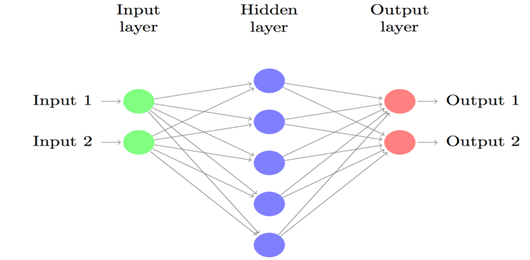

###**Step 5: Implementation**

Now we are ready for our implementation. We start by defining some useful variables and parameters for gradient descent:

In [28]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input Layer dimensionality
nn_output_dim = 2 # output Layer dimensionality

# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # Learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

First implement the loss function. We use this to evaluate how well our model is doing:

In [29]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

We also implement a helper function to calculate the output of the network. It does forward propagation as defined above and returns the class with the highest probability.

In [30]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

Finally, here comes the function to train our Neural Network. It implements batch gradient descent using the backpropagation derivates we found above.

In [33]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))
 
    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):
 
        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
 
        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)
 
        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1
 
        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

###**Step 6: A network with a hidden layer of size 3**

Let's see what happens if we train a network with a hidden layer size of 3.

Loss after iteration 0: 0.432387
Loss after iteration 1000: 0.068947
Loss after iteration 2000: 0.068888
Loss after iteration 3000: 0.070752
Loss after iteration 4000: 0.070748
Loss after iteration 5000: 0.070751
Loss after iteration 6000: 0.070754
Loss after iteration 7000: 0.070756
Loss after iteration 8000: 0.070757
Loss after iteration 9000: 0.070758
Loss after iteration 10000: 0.070758
Loss after iteration 11000: 0.070758
Loss after iteration 12000: 0.070758
Loss after iteration 13000: 0.070758
Loss after iteration 14000: 0.070758
Loss after iteration 15000: 0.070758
Loss after iteration 16000: 0.070758
Loss after iteration 17000: 0.070758
Loss after iteration 18000: 0.070758
Loss after iteration 19000: 0.070758


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: The following kwargs were not used by contour: 'Ñmap'
  


Text(0.5, 1.0, 'Desicion Boundary for hidden layer size 3')

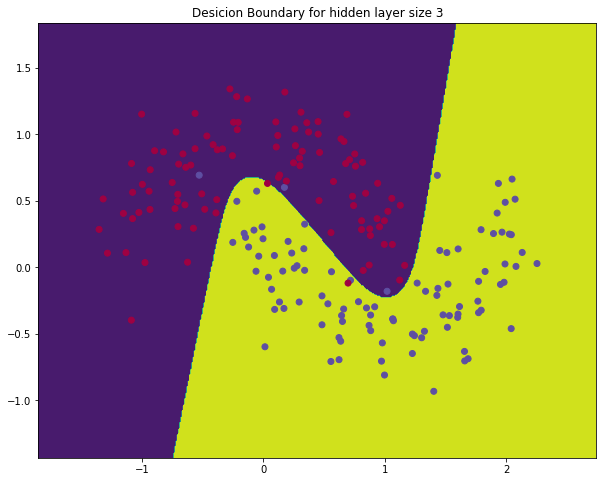

In [34]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)
 
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Desicion Boundary for hidden layer size 3")

This looks pretty good. Our neural networks was able to find a decision boundary that successfully separates the classes.

###**Step 7: Varying the hidden layer size**

In the example above we picked a hidden layer size of 3. Let's now get a sense of how varying the hidden layer size affects the result.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: The following kwargs were not used by contour: 'Ñmap'
  


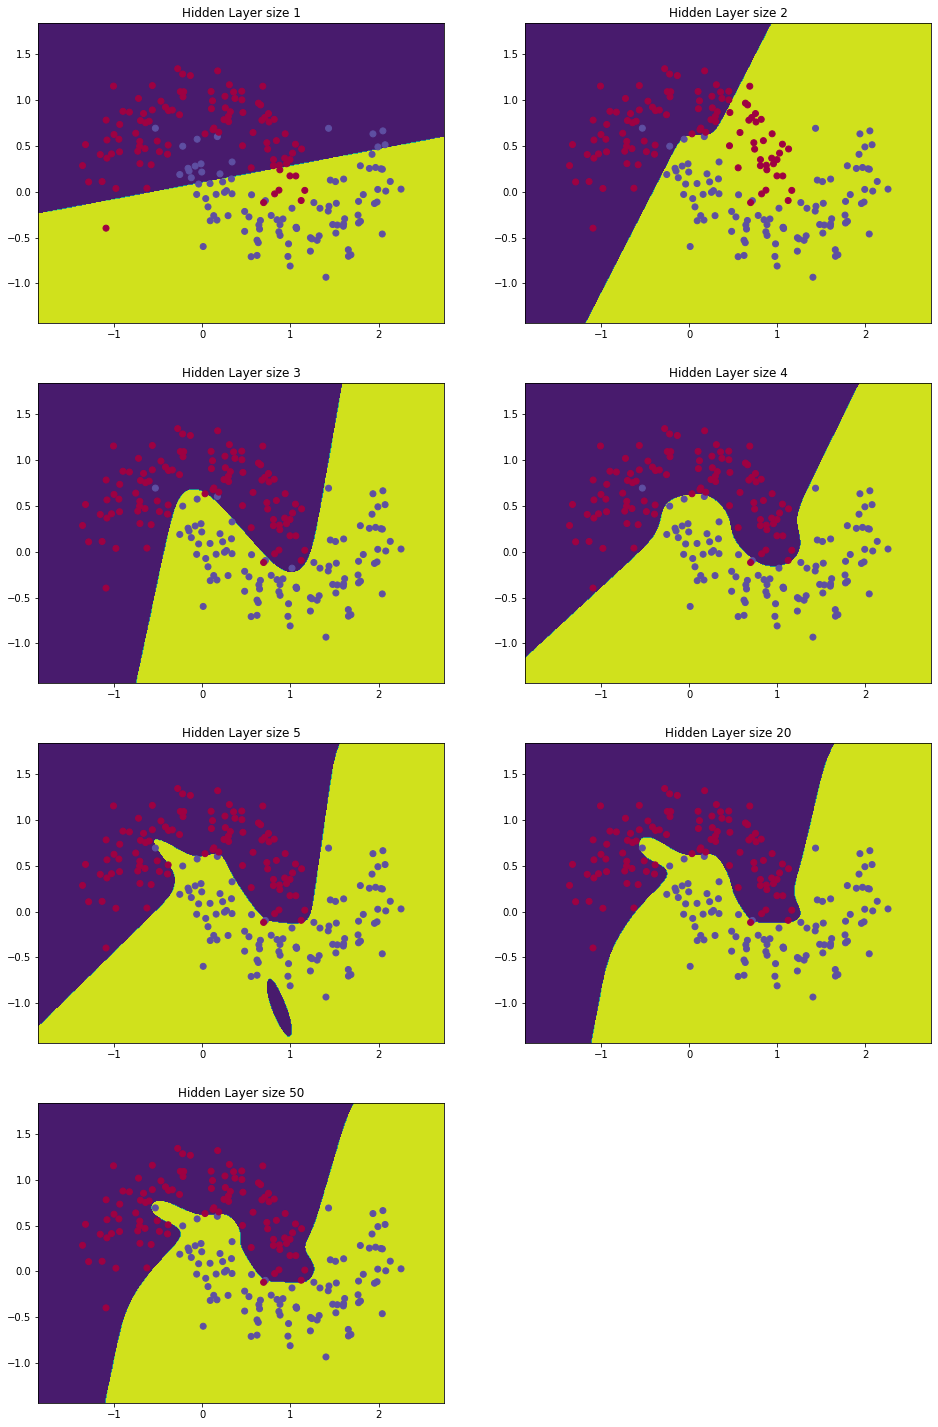

In [35]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()

References:
https://www.investopedia.com/terms/n/neuralnetwork.asp
http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
https://github.com/dennybritz/nn-from-scratch
